<a href="https://colab.research.google.com/github/adityaraghavan98/SHAP_tutorial/blob/main/01_SHAP_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Tutorial – Part 1: Basics

This notebook introduces the core ideas of **SHAP (SHapley Additive exPlanations)**
using a **simple regression example**. The goals are:

- Understand **what SHAP values are** at a high level  
- See how to compute SHAP values for a trained model  
- Learn how to **interpret** common SHAP plots  

We start with a small synthetic dataset and a tree-based regression model.


## 1. Setup

We will use:

- `numpy`, `pandas` for data handling  
- `scikit-learn` for the model  
- `shap` for explanations  
- `matplotlib` for plotting  

If `shap` is not installed, uncomment the `pip install` line below.


In [1]:
# If running locally or in a fresh Colab runtime, you may need:
# !pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

# Ensure nice plotting inside notebooks
plt.rcParams["figure.figsize"] = (6, 4)


## 2. Create a simple synthetic dataset

We build a small dataset with three input features:

- `x1`: main useful signal (linear effect)  
- `x2`: nonlinear effect (squared term)  
- `x3`: mostly noise  

The target `y` is a combination of these with some added noise.


In [2]:
rng = np.random.default_rng(0)
n_samples = 400

x1 = rng.uniform(-3, 3, size=n_samples)
x2 = rng.uniform(-2, 2, size=n_samples)
x3 = rng.normal(0, 1, size=n_samples)

# Define the target: main contributions from x1 and x2, little from x3
y = 2.0 * x1 + 0.5 * (x2 ** 2) + 0.2 * x3 + rng.normal(0, 0.5, size=n_samples)

X = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3})
y = pd.Series(y, name="y")

X.head()

,x1,x2,x3
0,0.821770,-1.191328,-1.209627
1,-1.381280,1.751620,-1.733003
2,-2.754159,-1.620893,-1.154171
3,-2.900834,-1.980402,1.420800
4,1.879621,-0.708317,-0.175857


## 3. Train a model

We use a **RandomForestRegressor** because:

- It can model nonlinearities (e.g., the squared term)  
- It works well with SHAP's tree explainer  

We will split the data into training and test sets.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

model = RandomForestRegressor(
    n_estimators=200,
    random_state=0
)
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train R^2: {train_score:.3f}")
print(f"Test  R^2: {test_score:.3f}")

Train R^2: 0.996
Test  R^2: 0.967


## 4. Quick look at feature importances (model-centric)

Tree-based models in scikit-learn expose a built-in measure of **feature importance**.
This is model-specific and not always easy to interpret for individual predictions,
but it gives a first sense of which features matter globally.


x1: 0.971
x2: 0.020
x3: 0.009


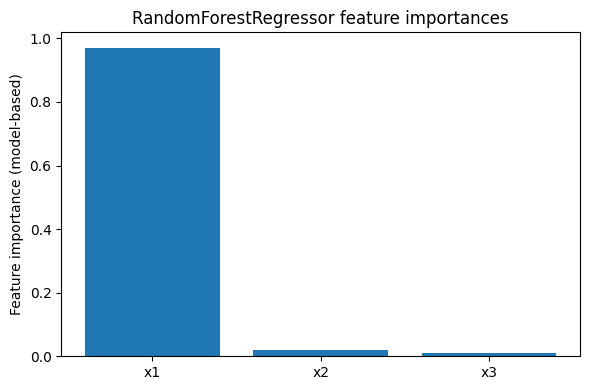

In [4]:
importances = model.feature_importances_
for name, val in zip(X.columns, importances):
    print(f"{name}: {val:.3f}")

plt.bar(X.columns, importances)
plt.ylabel("Feature importance (model-based)")
plt.title("RandomForestRegressor feature importances")
plt.tight_layout()
plt.show()

## 5. SHAP concepts (high level)

SHAP values come from **cooperative game theory**. Intuitively, they answer:

> *For a given prediction, how much did each feature contribute relative to some baseline?*

Key ideas:

- Each feature is treated as a **player** in a game that predicts `y`  
- The SHAP value for feature *i* is the **average marginal contribution** of *i*  
  across all possible subsets of features  
- SHAP values sum to the difference between the model prediction and a baseline
  (e.g., average prediction on the training data)

In practice, we do not compute all subsets explicitly. `shap` provides efficient
approximations, especially for tree-based models.


## 6. Compute SHAP values using TreeExplainer

We use a subset of the training data as our **background**.
This represents the "typical" data distribution used to define the baseline prediction.


In [5]:
# Use a subset of training data as background
background = X_train.sample(100, random_state=0)

explainer = shap.TreeExplainer(model, data=background)
# Compute SHAP values for the test set
shap_values = explainer(X_test)

# The object contains:
# - shap_values.values: array of SHAP values (n_samples, n_features)
# - shap_values.base_values: baseline prediction for each sample
type(shap_values)

shap._explanation.Explanation

## 7. Global view: SHAP summary plot

The **summary plot** shows:

- which features matter most **on average**, and  
- how feature values affect the direction of the SHAP contribution.

Each point is one sample; the horizontal position is the SHAP value (impact on prediction).


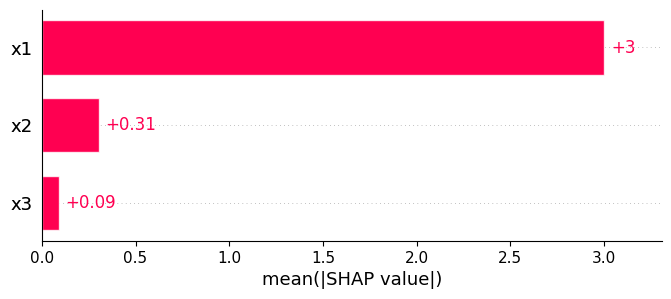

In [18]:
shap.plots.bar(shap_values)


### Why we show two types of summary plots

The **bar summary plot** (mean absolute SHAP values) gives a *simple global ranking*
of which features matter most on average.

The **beeswarm summary plot** goes deeper:
it shows the *full distribution* of SHAP values for each feature, and how
high/low feature values affect the prediction.

Together, these two plots give a clear global picture:
- the bar plot tells us **which features are important**,  
- the beeswarm plot tells us **how** each feature influences the model.


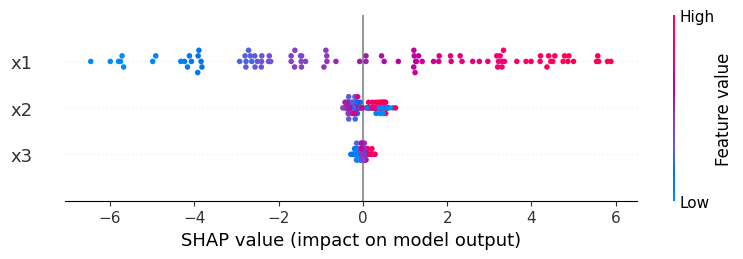

In [6]:
shap.summary_plot(shap_values.values, X_test, feature_names=X.columns)

### How to interpret this plot

- The vertical order shows **feature importance** (top = most important).  
- Each dot is a sample; left/right shows negative/positive impact on prediction.  
- Color shows whether the feature value is high (pink) or low (blue).  

This helps us see interactions, patterns, and how feature values change the direction
of their effect.


## 8. Feature-wise view: dependence plots

A **dependence plot** shows how a single feature influences the prediction,
while still accounting for interactions with other features.

Here we plot SHAP values for `x1` and `x2`.


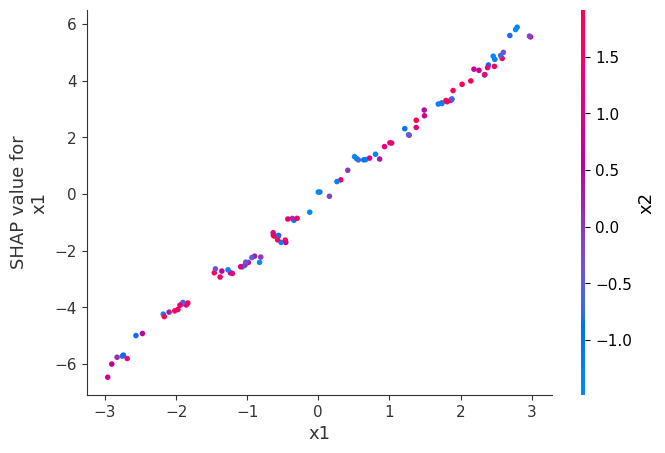

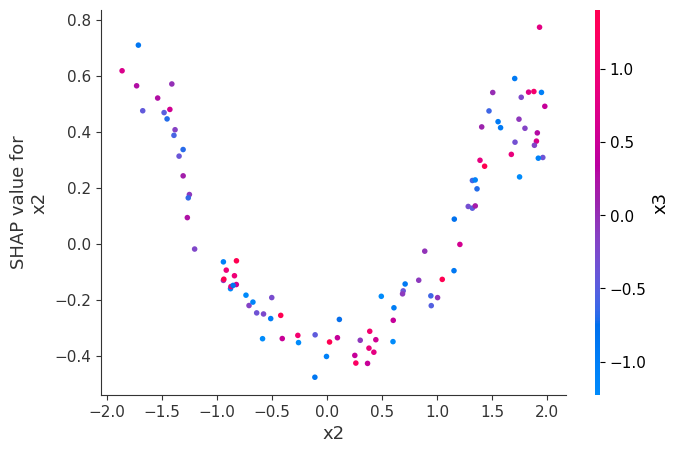

In [7]:
shap.dependence_plot("x1", shap_values.values, X_test, feature_names=X.columns)
shap.dependence_plot("x2", shap_values.values, X_test, feature_names=X.columns)

### How to read these dependence plots

Each plot shows how a single feature influences the model’s prediction:

- The **x-axis** is the raw feature value (e.g., `x1`, `x2`).  
- The **y-axis** is the SHAP value for that feature, showing how much it pushes the prediction up or down.  
- **Colors** reflect another interacting feature (chosen automatically by SHAP), which helps reveal interaction effects.

In this synthetic dataset:
- `x1` shows a mostly **linear** relationship — larger values increase the prediction.  
- `x2` shows a **curved / quadratic** pattern — the model has learned a nonlinear effect.

Dependence plots help us understand the **shape of the learned relationship**, not just whether a feature is important.


## 9. Local explanation: a single prediction

For a single test point, we can inspect its SHAP values and see
how each feature pushed the prediction up or down relative to the baseline.

We use the **waterfall plot** for a clear decomposition.


True target: 5.1130519794309786
Model prediction: 4.14108396829212


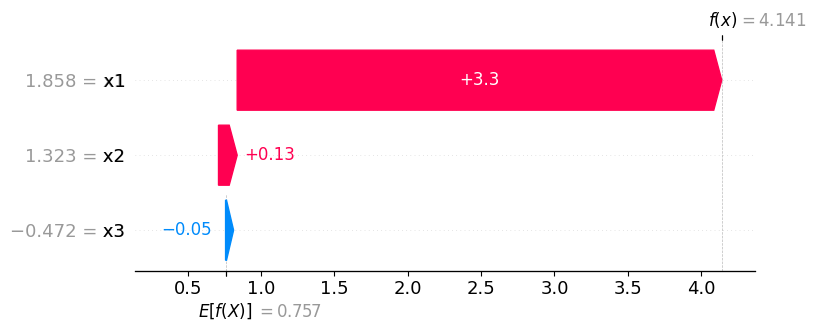

In [8]:
# Pick one example
idx = 0
x_sample = X_test.iloc[[idx]]
y_true = y_test.iloc[idx]
y_pred = model.predict(x_sample)[0]

print("True target:", y_true)
print("Model prediction:", y_pred)

shap.waterfall_plot(shap.Explanation(
    values=shap_values.values[idx],
    base_values=shap_values.base_values[idx],
    data=x_sample.values[0],
    feature_names=list(X.columns)
))

### How to interpret the waterfall plot

The waterfall plot explains **one single prediction** in detail.

- The gray value on the left is the **baseline** (the average model prediction).  
- Each bar shows how a feature **pushes the prediction up (pink)** or **down (blue)**.  
- The final value on the right is the **model’s actual prediction** for this sample.

This plot answers the question:
> “Why did the model predict this specific value?”

Unlike the global plots, the waterfall plot focuses on **local interpretability** —  
showing exactly how the model combined individual feature contributions
to produce one prediction.


## 10. Real-world example: California housing data

So far we used a **tiny synthetic dataset** to build intuition.

In this section, we:

- Load the **California housing** dataset from scikit-learn  
- Train another tree-based model  
- Use SHAP to understand which features drive house prices  
- Look specifically at how **location (latitude)** affects value

This is closer to how SHAP is used in practice: explaining a
real dataset with multiple, interacting features.


In [9]:
from sklearn.datasets import fetch_california_housing

# Load dataset as a pandas DataFrame
housing = fetch_california_housing(as_frame=True)
df_h = housing.frame.copy()

# Target is median house value
y_real = df_h["MedHouseVal"]
X_real = df_h.drop(columns=["MedHouseVal"])

print("Shape:", X_real.shape)
X_real.head()

Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
# Train a tree-based model on the real data
model_real = RandomForestRegressor(
    n_estimators=300,
    random_state=0,
    n_jobs=-1
)
model_real.fit(X_real, y_real)

print("Train R^2:", model_real.score(X_real, y_real))

Train R^2: 0.9748527120561653


In [11]:
# The below code takes near 15 mins. Skip this and load the shap values in the next cell if you don't want to spend ~15 mins
"""# Compute SHAP values for a sample of the real data
# (Using a subset keeps computations and plots fast)
background_real = X_real.sample(1000, random_state=0)
explainer_real = shap.TreeExplainer(model_real, data=background_real)

X_real_sample = X_real.sample(2000, random_state=1)
shap_values_real = explainer_real(X_real_sample)

shap_values_real"""

'# Compute SHAP values for a sample of the real data\n# (Using a subset keeps computations and plots fast)\nbackground_real = X_real.sample(1000, random_state=0)\nexplainer_real = shap.TreeExplainer(model_real, data=background_real)\n\nX_real_sample = X_real.sample(2000, random_state=1)\nshap_values_real = explainer_real(X_real_sample)\n\nshap_values_real'

In [12]:
import numpy as np
import urllib.request
import io
import shap

url = "https://raw.githubusercontent.com/adityaraghavan98/SHAP_tutorial/main/shap_california_precomputed.npz"

with urllib.request.urlopen(url) as f:
    data_bytes = f.read()

data = np.load(io.BytesIO(data_bytes), allow_pickle=True)

shap_values_real = shap.Explanation(
    values=data["values"],
    base_values=data["base_values"],
    data=data["X"],
    feature_names=list(data["feature_names"])
)

print("Loaded successfully!")


Loaded successfully!


In [13]:
# --- Restore required variables for the interactive section ---

# X_real came from the California housing dataset
# If it's not defined (because you skipped earlier cells), reload it:
try:
    X_real
    y_real
except NameError:
    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing(as_frame=True)
    df_h = housing.frame.copy()
    y_real = df_h["MedHouseVal"]
    X_real = df_h.drop(columns=["MedHouseVal"])

# X_real_sample comes from the precomputed file
X_real_sample = pd.DataFrame(data["X"], columns=data["feature_names"])

# model_real must also be reloaded if the training cell is skipped:
try:
    model_real
except NameError:
    model_real = RandomForestRegressor(
        n_estimators=300,
        random_state=0,
        n_jobs=-1
    )
    model_real.fit(X_real, y_real)

print("Variables restored. You can now run the SHAP waterfall section.")


Variables restored. You can now run the SHAP waterfall section.


### 10.1 Interpreting SHAP on real data: location matters

The California housing dataset includes:

- **Latitude** and **Longitude** (where the house is)  
- **MedInc** (median income in the area)  
- **HouseAge**, **AveRooms**, etc.

We know from domain knowledge that **location strongly affects price**.
We can let SHAP show us this pattern and how it interacts with other features.

The plot below shows:

- Each point: one house from our sample  
- Horizontal axis: SHAP value for **Latitude** (how much that house's latitude
  pushes the prediction up or down)  
- Color: another feature (by default, SHAP picks an interacting feature)

Clusters in this plot tell us where **latitude** is most beneficial or harmful
for the predicted house value.


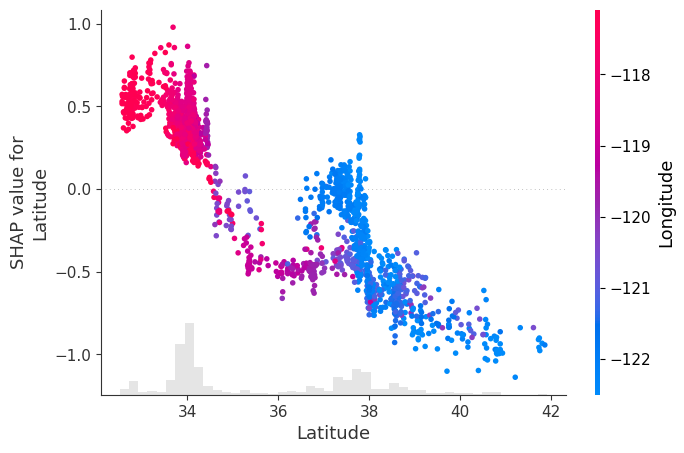

In [14]:
# Scatter SHAP plot for Latitude
# Each point is a house; horizontal axis is contribution of Latitude
shap.plots.scatter(shap_values_real[:, "Latitude"], color=shap_values_real)

### What this plot tells us

- Each point is a single house from our sample.  
- The **x-axis** is the house’s `Latitude`.  
- The **y-axis** is the SHAP value for `Latitude`, i.e. how much that latitude
  pushes the predicted price up (positive) or down (negative),
  relative to the average house.
- The **color** encodes another feature (here, `Longitude`), so we see how
  latitude and longitude interact.

Interpretation:

- For many houses at lower latitudes, the SHAP value is **positive**:
  those locations increase the predicted house value.
- As latitude increases, SHAP values for `Latitude` tend to become **negative**:
  those locations decrease the predicted value.
- The color gradient shows that this pattern is not just latitude alone –
  latitude and longitude together define “expensive regions” versus cheaper ones.

Overall: **location (lat/long) has a clear, nonlinear effect on price**, and SHAP lets
us see how specific latitude bands contribute to the model’s prediction.


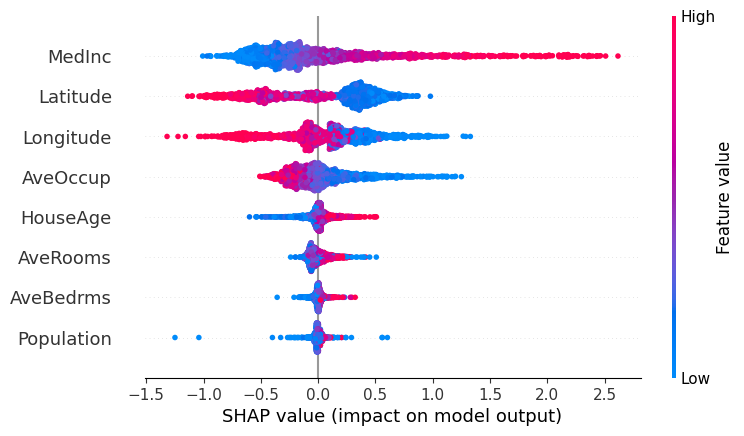

In [15]:
# Global view for the real data: which features matter overall?
shap.plots.beeswarm(shap_values_real, max_display=10)

### Global SHAP summary: which features matter most?

This beeswarm plot is a **global view** of feature importance:

- Each horizontal strip is one feature.  
- Each point is a house.  
- Horizontal position = SHAP value (how much that feature moves the prediction).  
- Color = actual feature value (high = pink, low = blue).

Key observations:

- **`MedInc` (median income)** has the widest spread of SHAP values:
  it is the **most important driver** of predicted house value.
  High incomes (pink points on the right) strongly increase predictions.
- **`Latitude` and `Longitude`** are also very important:
  certain locations consistently increase or decrease predicted prices.
- Other variables like **`HouseAge`, `AveRooms`, `AveOccup`** have smaller spreads:
  they still matter, but their impact is weaker than income and location.

Takeaway: the model has learned that **income and location** are the dominant
factors for house prices in this dataset, and SHAP quantifies this effect for
every individual house.


## 11. Try it yourself: explore SHAP for individual houses

As a next step, you can:

1. Pick a specific house from our sampled dataset  
2. Look at its SHAP **waterfall plot**  
3. See exactly how each feature pushed the model's prediction up or down

You can change the `sample_index` below to explore different houses.


Sample index: 5
Model prediction (MedHouseVal): 2.878



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
5,7.3715,17.0,5.006098,0.993902,229.0,1.396341,34.15,-118.16


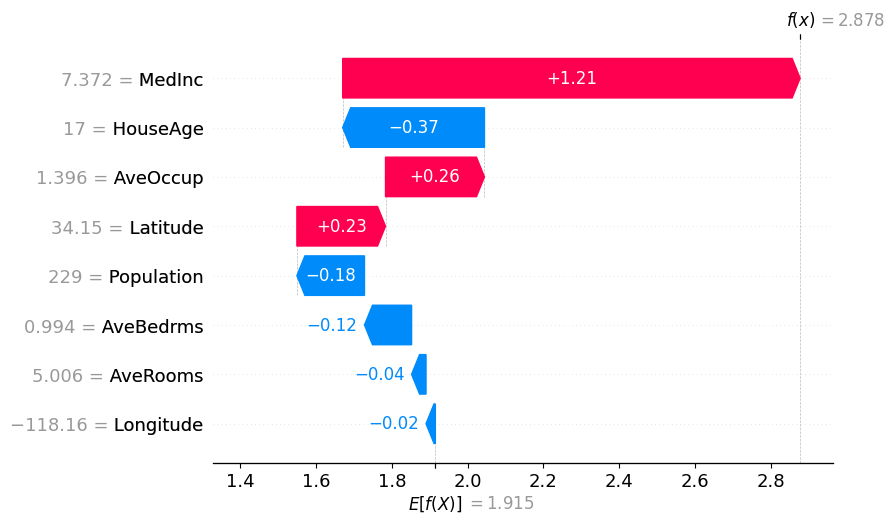

In [17]:
# Choose which house to inspect (0 <= index < len(X_real_sample))
sample_index = 5   # <-- change this number and re-run to explore

# Extract the corresponding row and SHAP values
x_house = X_real_sample.iloc[[sample_index]]
y_pred_house = model_real.predict(x_house)[0]

print(f"Sample index: {sample_index}")
print(f"Model prediction (MedHouseVal): {y_pred_house:.3f}\n")
display(x_house)

# Build a SHAP Explanation for this single sample
shap_expl_house = shap.Explanation(
    values=shap_values_real.values[sample_index],
    base_values=shap_values_real.base_values[sample_index],
    data=x_house.values[0],
    feature_names=list(X_real.columns)
)

shap.plots.waterfall(shap_expl_house)